In [1]:
import os
os.environ['PATH'] += ':/home/oslab/Luminescent/bin'

running luminescent python frontend
2025-05-27 02:05:44.097 | WARNING  | kfactory.kcell:show:3516 - Could not connect to klive server


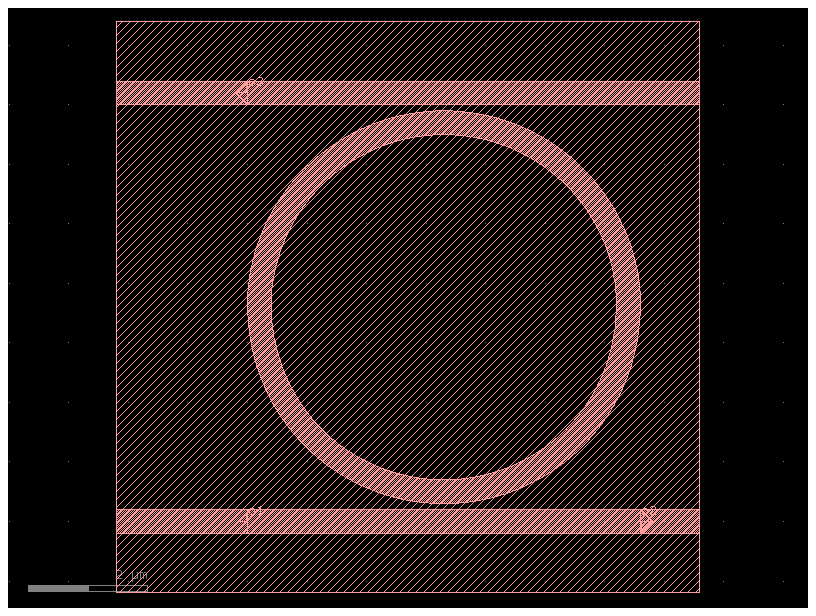

In [2]:
"""
Ring resonator sparams similar to [Lumerical example](https://optics.ansys.com/hc/en-us/articles/360042800293-Ring-resonator-getting-started-Design-and-initial-simulation). Lossy, FSR of few nm around 1.55um. Takes a long time because signal goes round and round before decaying.

Big and long running 3D simulation
30min on CPU
"""

import luminescent as lumi
from luminescent import OVERRIDE, WG, BBOX
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import numpy as np
import os
import math

path = os.path.join("runs", "ring")
wavelengths = np.linspace(1.5, 1.6, 201)  # [um]

# length units are arbitrary so long as they are consistent
radius = 3
width = 0.4
gap = 0.1  # gap between waveguide and ring
thickness = 0.18  # thickness of waveguide

# margins
source_port_margin = 2
zmargin_mode = 0.6
xmargin_mode = 0.6

# make component in gdsfactory. `gf.components` defaults to layer (1, 0) (WG)
#  alternatively can import .gds into gdsfactory
c = gf.Component()

dut = c << gf.components.ring(radius=radius, width=width, layer=WG)
dut.move((radius + width / 2, width + gap + radius))

wg1 = c << gf.components.straight(length=2 * radius + width, width=width)
wg2 = c << gf.components.straight(length=2 * radius + width + 1, width=width)
wg2.movey(2 * (width + gap + radius))

ext1 = c << gf.components.straight(length=1.1 * source_port_margin, width=width)
ext3 = c << gf.components.straight(length=1.1 * source_port_margin, width=width)
ext2 = c << gf.components.straight(length=1, width=width)
ext1.connect("o2", wg1.ports["o1"])
ext2.connect("o1", wg1.ports["o2"])
ext3.connect("o2", wg2.ports["o1"])

c << gf.components.bbox(component=c, layer=BBOX, top=1, bottom=1)

c.add_port("o1", port=wg1.ports["o1"])
c.add_port("o2", port=wg1.ports["o2"])  # thru channel
c.add_port("o3", port=wg2.ports["o1"])  # drop channel
c.flatten()

c.draw_ports()  # optional. caution: make sure annotation doesn't change overall bounding box
c.show()
c.plot()


xmargin_mode: [0.6, 0.6]
using simulation folder runs/ring
loading problem from /home/oslab/Luminescent.jl/runs/ring

running Luminescent julia backend
λ = F(center_wavelength) = 1.55f0
setting up simulation...
meshing geometry - can take few minutes...
857.566575 seconds (632.88 M allocations: 709.671 GiB, 7.54% gc time, 0.74% compilation time)
making sources...
solving modal profile...
making monitors...
solving modal profile...
solving modal profile...
solving modal profile...
making designs...
----------------------------------------

simulation setup complete

backend: CPU
float: Float32

original size: (132, 119, 15)
padded size: (154, 135, 19)
cell count: 395,010

step size: 45.0 steps/period
max time: 500.00 periods
field decay threshold: 0.001

compiling simulation code...
accumulating dft fields...
period 0.00, 0.01 seconds/period
period 5.00, E/Epeak 0.7726, 22.27 seconds/period
period 10.00, E/Epeak 0.6564, 14.41 seconds/period
period 15.00, E/Epeak 0.6498, 11.85 seconds/pe

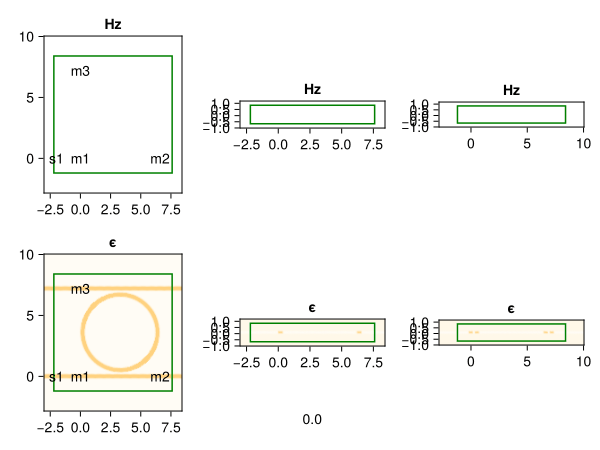

In [3]:
# layer stack. lower mesh order layers supplant higher mesh order layers
SOI180 = LayerStack(
    layers={
        "core": LayerLevel(
            layer=LogicalLayer(layer=WG),
            thickness=thickness,
            zmin=0.0,
            material="Si",
            mesh_order=1,
        ),
        "clad": LayerLevel(
            layer=LogicalLayer(layer=BBOX),
            thickness=5,
            zmin=thickness,
            material="SiO2",  # or 'air'
            mesh_order=2,
        ),
        "sub": LayerLevel(
            layer=LogicalLayer(layer=BBOX),
            thickness=5,
            zmin=-5,
            material="SiO2",
            mesh_order=3,
        ),
    }
)

# custom materials entries replace default values
materials = {**lumi.MATERIALS, **{"Si": {"epsilon": 3.476**2}}}

lumi.make_prob(
    path,  # path to make simulation folder
    component=c,
    #
    wavelengths=wavelengths,
    keys=["o2@0,o1@0", "o3@0,o1@0"],  # sparameters, eg optical port 2 on mode 0
    #
    zmin=-1.1 * zmargin_mode,
    zmax=thickness + 1.1 * zmargin_mode,
    zmargin_mode=zmargin_mode,
    xmargin_mode=xmargin_mode,
    source_port_margin=source_port_margin,
    #
    materials=materials,
    layer_stack=SOI180,
    #
    nres=6,  # number of grid points per wavelength in material (not vacuum)
    relcourant=0.8,  # relative courant number between 0 and 1
    relpml=[1, 1, 0.2],  # relative PML thicknesses
    T=500,  # max time [periods]
    field_decay_threshold=0.001,  # field decay threshold for stopping simulation
    #
    saveat=5,  # save field every n periods
    force=True,  # delete and overwrite existing path
)
lumi.solve(path)  # solves simulation and saves results to path
lumi.make_movie(path)

loading solution from /home/oslab/Luminescent.jl/runs/ring


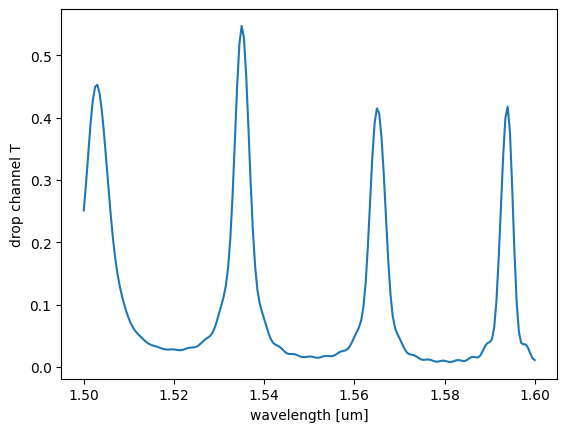

In [4]:
import matplotlib.pyplot as plt

path = os.path.join("runs", f"ring")
sol = lumi.load_sol(path)
x = wavelengths
y = sol["T"]["o3@0,o1@0"]  # wavelength or frequency ordered depending on problem setup
plt.plot(x, y)
plt.xlabel("wavelength [um]")
plt.ylabel("drop channel T")
plt.show()